In [32]:
# %%writefile prelim_model.py
import numpy as np
import pandas as pd
from pymongo import MongoClient
import pprint
import string
import re
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import normalize
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix

from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet  import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams, skipgrams


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB#, ComplementNB unreleased as of 12/14

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# connect to mongodb
client = MongoClient() # defaults to localhost
db = client.bills
bill_details = db.bill_details


# print out record counts with text
print('--> Number of records in database: {}'.format(bill_details.find().count()))

records_with_text = bill_details.find({'body': {'$regex': 'e'}})
record_count = records_with_text.count()

print('--> Current number of records with text: {}'.format(record_count))

# convert mongo query resuls to dataframe
# need to execute query (.find) everytime i refer to it?
records_with_text = bill_details.find({'body': {'$regex': 'e'}})
data = pd.DataFrame(list(records_with_text))

# filter out simple resolutions, concurrent resolutions, and amendments (for prelim model)
data = data[(data['leg_type'] != 'RESOLUTION') & (data['leg_type'] != 'CONCURRENT RESOLUTION') & (data['leg_type'] != 'AMENDMENT')]


# LABELS

# Every record that doesn't have status Became Law will have label 0 if before current (115th) congress.
# plan is to use one label ('passed') initially.
# Try this out with 3 labels.

#  

#                             Whole     House     Senate
# Introduced:                 None      None      None
# Became Law:                 1         1         1
# Passed House:               None      1         None
# To President:               1         1         1
# Resolving Differences:      1         1         1
# Failed House:               0         0         1 if S
# Became Private Law:         1         1         1
# Passed Senate:              None      None      1
# Failed to pass over veto:   1         1         1
# Vetoed by President:        1         1         1
# Passed over veto:           1         1         1     #stronger support for this one???
# Pocket vetoed by President: 1         1         1
# Failed Senate:              0         1 if H    0


# check numbers for each status
print('-----------------')
print('-----------------')
print('\tCount for each bill_status: ')
for i in data.bill_status.unique():
    num = len(data[data['bill_status'] == i])
    print('{}: \t\t{}'.format(i, num))

# create columns for labels
# data['house_label'] = None
# data['senate_label'] = None
# data['president_label'] = None
data['passed'] = None

orig_shape = data.shape
print('-----------------')
print('-----------------')
print('Shape of entire data before labeling: {}'.format(orig_shape))
print('-----------------')


# break up dataframe into those that became law and others (did not or still pending)
became_law = data[(data['bill_status'] == 'Became Law') | (data['bill_status'] == 'Became Private Law')]
others = data[(data['bill_status'] != 'Became Law') & (data['bill_status'] != 'Became Private Law')]

became_law.loc[:, 'passed'] = 1



# break up others into current congress and previous ones. Anything that hasn't been signed into law
# before current session is dead. Currently, all bills vetoed by the president come from previous congresses
current_cong = others[others['congress_id'] == '115th']
prev_cong = others[others['congress_id'] != '115th']

prev_cong.loc[:, 'passed'] = 0



# let's label To President and Resolving Differences with 1. Everything else is on the floor
to_pres = current_cong[(current_cong['bill_status'] == 'To President') | (current_cong['bill_status'] == 'Resolving Differences')]
on_floor = current_cong[(current_cong['bill_status'] != 'To President') & (current_cong['bill_status'] != 'Resolving Differences')]

to_pres.loc[:, 'passed'] = 1



# break up bills on the floor to failed (0) and not failed
failed = on_floor[on_floor['bill_status'].str.startswith('Failed')]
not_failed = on_floor[~on_floor['bill_status'].str.startswith('Failed')]

failed.loc[:, 'passed'] = 0



# bills that haven't failed yet have either been just introduced or on their way
# label introduced with 'in_progress'. These will not be a part of our model.
introduced = not_failed[not_failed['bill_status'] == 'Introduced']
beyond_intro = not_failed[not_failed['bill_status'] != 'Introduced']

introduced.loc[:, 'passed'] = 'in_progress'



# there are bills that started in one chamber and have already passed the other. We'll label
# these with a 1
passed_opp_chamber = beyond_intro[(beyond_intro['bill_status'] == 'Passed House') & (beyond_intro['leg_id'].str.startswith('S')) | 
                          (beyond_intro['bill_status'] == 'Passed Senate') & (beyond_intro['leg_id'].str.startswith('H'))]

passed_opp_chamber.loc[:, 'passed'] = 1



# bills that are still in the chamber they were introduced in are 'in_progress'
in_orig_chamber = beyond_intro[(beyond_intro['bill_status'] == 'Passed House') & (beyond_intro['leg_id'].str.startswith('H')) | 
                          (beyond_intro['bill_status'] == 'Passed Senate') & (beyond_intro['leg_id'].str.startswith('S'))]    

in_orig_chamber.loc[:, 'passed'] = 'in_progress'



# bring all the information back together
data_l = pd.concat([became_law, prev_cong, to_pres, failed, introduced, passed_opp_chamber, in_orig_chamber])

labeled_shape = data_l.shape
print('----------------')
print('Shape of entire data after labeling: {}'.format(labeled_shape))
print('----------------')

if orig_shape == labeled_shape:
    print('\tNo data loss upon labeling. Onward!')
else:
    print('\tYou lost {} lines upon labeling. You may want to examine your code.'.format(orig_shape[0] - labeled_shape[0]))


# filter out bills with label 'in_progress'
print('----------------')
print('----------------')
df = data_l[data_l['passed'] != 'in_progress']
print('Count of records being examined for each label:')
print(df.passed.value_counts())

# examine how much data we have for each congress_id
print('----------------')
print('Value counts for each congress:')
print(df.congress_id.value_counts())


# filter for most recent congress_ids
print('------------------')
print('Filtering for most recent congress_ids for analysis...')
small_df = df[(df['congress_id'] == '115th') | (df['congress_id'] == '114th') | (df['congress_id'] == '113th')]

In [5]:
############################## NLP
############################## NLP
############################## NLP
# create a corpus
documents = list(small_df['body'])

# remove numbers
documents = list(map(lambda x: ' '.join(re.split('[,_\d]+', x)), documents))

# tokenize the corpus
print('------------------')
print('Created corpus, now tokenizing it...')
corpus = [word_tokenize(content.lower()) for content in documents]

# strip out the stop words from each 
print('------------------')
print('Stripping out stop words, punctuation, and numbers...')
stop_words = stopwords.words('english')
stop_words.extend(['mr', 'ms', 'mrs', 'said', 'year', 'would', 'could', 'also', 'shall', '_______________________________________________________________________'])
# print(stop_words)
corpus = [[token for token in doc if token not in stop_words] for doc in corpus]
# corpus[0]

# strip out the punctuation
punc = set(string.punctuation)
# print(punc)
corpus = [[token for token in doc if token not in punc] for doc in corpus]
# corpus[0]

# strip out the punctuation
string.digits


# lemmatize (and maybe stem?)
print('------------------')
print('Lemmatizing...')
lemmer = WordNetLemmatizer()
corpus = [[lemmer.lemmatize(word) for word in doc] for doc in corpus]
# corpus[0]

# build a vocabulary
print('------------------')
print('Creating a vocabulary...')
vocab_set = set()
[[vocab_set.add(token) for token in tokens] for tokens in corpus]
vocab = list(vocab_set)
# vocab[100000:100020]

# # for later model...
# # examine n-grams...
# # bigrams (two words side-by-side)
# print('------------------')
# print('Creating lists of bigrams, trigrams, skipgrams, etc...')
# bigrams = [list(ngrams(sequence = doc, n = 2)) for doc in corpus]
# trigrams = [list(ngrams(sequence = doc, n = 3)) for doc in corpus]
# #... more?

# # skipgrams (n-grams that skip k words)
# skipgrams = [list(skipgrams(sequence = doc, n = 2, k = 1)) for doc in corpus]


# rejoin each doc in corpus so each doc is a single string
corpus = [' '.join(tokens) for tokens in corpus]

print('------------------')
print('NLP preprocessing complete ...')

print('------------------')
print('Creating train-test split and vectorizing ...')
X = corpus
y = small_df['passed'].astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

------------------
Created corpus, now tokenizing it...
------------------
Stripping out stop words, punctuation, and numbers...
------------------
Lemmatizing...
------------------
Creating a vocabulary...
------------------
NLP preprocessing complete ...
------------------
Creating train-test split and vectorizing ...


In [33]:
# # create a bag of words. CountVectorizer allows us to build a term frequency matrix
# print('------------------')
# print('Using CountVectorizer to create a term frequency matrix...')
# cv = CountVectorizer(stop_words = 'english')
# bag_of_words = cv.fit(X_train)

# # create a feature dictionary with indices
# # The same can be done with tfidfvectorizer
# print('------------------')
# print('Creating vocabulary and feature list...')
# feature_dict = bag_of_words.vocabulary_
# # print(feature_dict)

# # create an alphabetical feature list
# feature_list = bag_of_words.get_feature_names()
# # print(feature_list)

# # convert to a term frequency matrix. This is a sparse array. 
# term_freq_matrix = cv.fit_transform(X_train).toarray()
# # print(term_freq_matrix)

a_list = []
r_list = []
p_list = []


# TF-IDF vectorizer
for i in range(200, 4200, 200):
    
    tfvect = TfidfVectorizer(max_features = i)
    X_train_vec = tfvect.fit_transform(X_train)
    X_test_vec = tfvect.transform(X_test)

    nb = MultinomialNB()
    nb.fit(X_train_vec, y_train)
    y_pred = nb.predict(X_test_vec).astype('int')
    
    a_score = accuracy_score(y_test, y_pred)
    r_score = recall_score(y_test, y_pred)
    p_score = precision_score(y_test, y_pred)
    
    a_list.append(a_score)
    r_list.append(r_score)
    p_list.append(p_score)

    
#     print('--------------------')
#     print('--> Multinomial Naive Bayes predictions after TFIDFVectorizer')
#     print(' --> max_features: {}'.format(i))
#     print('Accuracy Score: {:.2f}'.format(a_score))
#     print('Recall Score: {:.2f}'.format(r_score))
#     print('Precision Score: {:.2f}'.format(p_score))
#     print('Confusion Matrix:')
#     print(confusion_matrix(y_test, y_pred, labels = [1, 0]))
#     print('--------------------')
    

In [13]:
def plot_it(x, y_list, name, labels):
    x = x
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot(111)
    ax.set_title(name, fontdict = {'fontsize': 20})
    for y in y_list:
        plt.plot(x, y)
    plt.legend(labels)

    plt.show

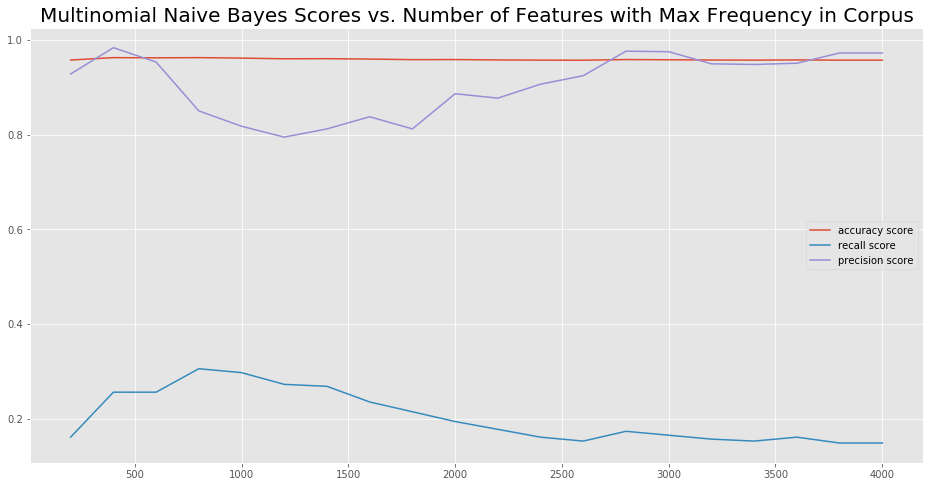

In [34]:
# show graph of scores vs. number of max_features 
x = np.arange(200, 4200, 200)
plot_list = [a_list, r_list, p_list]
graph_name = 'Multinomial Naive Bayes Scores vs. Number of Features with Max Frequency in Corpus'
labels = ['accuracy score', 'recall score', 'precision score']

plot_it(x, plot_list, graph_name, labels)

In [49]:
a_list = []
r_list = []
p_list = []

for i in range(0, 11):
    a = .1 * i
    tfvect = TfidfVectorizer(max_features = 5000)
    X_train_vec = tfvect.fit_transform(X_train)
    X_test_vec = tfvect.transform(X_test)

    nb = MultinomialNB(alpha = a)
    nb.fit(X_train_vec, y_train)
    y_pred = nb.predict(X_test_vec).astype('int')
    
    r_score = recall_score(y_test, y_pred)
    
    a_list.append(a_score)
    r_list.append(r_score)
    p_list.append(p_score)
   

/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


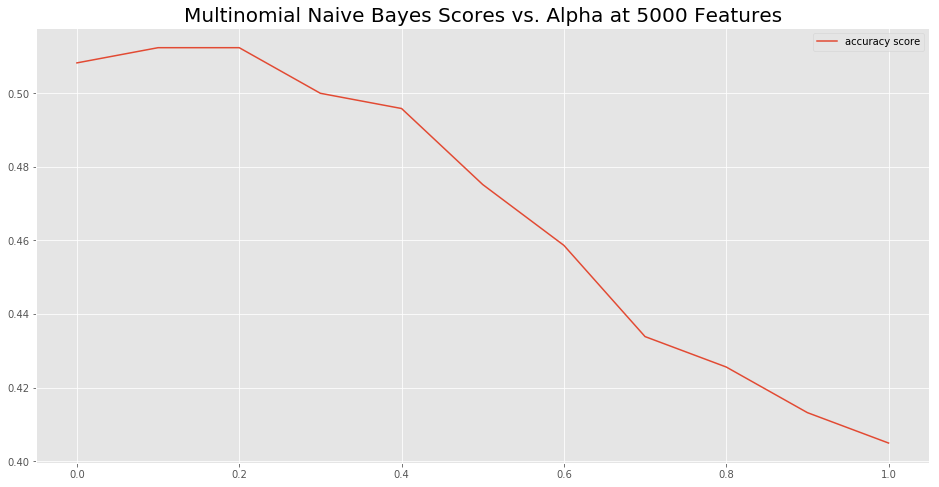

In [50]:
# show graph of scores vs. number of max_features 
x = np.arange(0, 1.1, .1)
plot_list = [r_list]
graph_name = 'Multinomial Naive Bayes Scores vs. Alpha at 5000 Features'
labels = ['accuracy score', 'recall score', 'precision score']

plot_it(x, plot_list, graph_name, labels)

In [51]:
r_list

[0.5082644628099173,
 0.512396694214876,
 0.512396694214876,
 0.5,
 0.49586776859504134,
 0.47520661157024796,
 0.45867768595041325,
 0.43388429752066116,
 0.4256198347107438,
 0.4132231404958678,
 0.4049586776859504]

In [29]:
# after determining the ideal number of features, vectorize again with the specified number
# to create the vocabulary for NMF
tfvect = TfidfVectorizer(max_features = 2800)
X_train_vec = tfvect.fit_transform(X_train)
X_test_vec = tfvect.transform(X_test)

vocabulary = tfvect.get_feature_names()

nb = MultinomialNB()
nb.fit(X_train_vec, y_train)
y_pred = nb.predict(X_test_vec).astype('int')
y_pred_proba = nb.predict_proba(X_test_vec)

a_score = accuracy_score(y_test, y_pred)
r_score = recall_score(y_test, y_pred)
p_score = precision_score(y_test, y_pred)

print('--------------------')
print('--> Multinomial Naive Bayes predictions after TFIDFVectorizer')
print(' --> max_features: {}'.format(i))
print('Accuracy Score: {:.2f}'.format(a_score))
print('Recall Score: {:.2f}'.format(r_score))
print('Precision Score: {:.2f}'.format(p_score))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred, labels = [1, 0]))
print('--------------------')

--------------------
--> Multinomial Naive Bayes predictions after TFIDFVectorizer
 --> max_features: 19
Accuracy Score: 0.97
Recall Score: 0.47
Precision Score: 0.82
Confusion Matrix:
[[ 114  128]
 [  25 4642]]
--------------------


In [25]:
# use non-negative matrix factorization to find the ideal number of topics
r_errors = []
for i in range(3, 20):
    nmf = NMF(n_components = i, alpha = 0.0)
    W = nmf.fit_transform(X_train_vec)
    H = nmf.components_
    r_errors.append(nmf.reconstruction_err_)
    

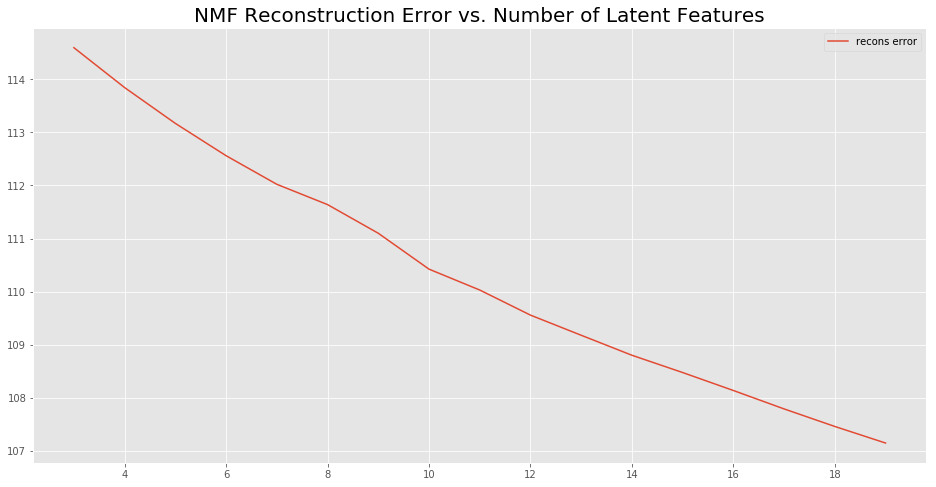

In [28]:
x = np.arange(3, 20)
graph_name = 'NMF Reconstruction Error vs. Number of Latent Features'
plot_it(x, [r_errors], graph_name, ['recons error'])

In [11]:
for topic in range(H.shape[0]):
    top_hits = H[topic].argsort()[:-100:-1].astype(int)
    top_words = [vocabulary[hits] for hits in top_hits]
    print('-------------')
    print('Topic {}'.format(topic + 1))
    print(top_words)

-------------
Topic 1
['shall', 'act', 'section', 'state', 'security', 'secretary', 'commission', 'subsection', 'agency', 'federal', 'information', 'service', 'health', 'paragraph', 'program', 'report', 'general', 'individual', 'sec', 'may', 'united', 'fund', 'term', 'ii', 'fiscal', 'person', 'title', 'including', 'plan', 'law', 'date', 'public', 'drug', 'member', 'inserting', 'social', 'available', 'described', 'department', 'requirement', 'provided', 'action', 'entity', 'homeland', 'subparagraph', 'covered', 'national', 'day', 'employee', 'director', 'foreign', 'committee', 'striking', 'use', 'system', 'activity', 'care', 'following', 'administrator', 'project', 'review', 'later', 'regulation', 'purpose', 'rule', 'enforcement', 'payment', 'alien', 'assistance', 'order', 'board', 'appropriate', 'authority', 'respect', 'amount', 'cost', 'period', 'data', 'congress', 'provide', 'defense', 'required', 'attorney', 'provision', 'amended', 'medicare', 'research', 'energy', 'appropriation', 

In [ ]:
H.shape

In [ ]:
H[0]

In [ ]:
def top_n(vectorizer, vectors, data, words, n):
    '''
    Print out the top 10 words by three different sorting mechanisms:
        * average tf-idf score
        * total tf-idf score
        * highest TF score across corpus
    '''
#     words = vectorizer.get_feature_names()

    # Top 10 words by average tfidf
    # Take the average of each column, denoted by axis=0
    avg = np.sum(vectors, axis=0) / np.sum(vectors > 0, axis=0)
    print ("top %d by average tf-idf" % n)
    print (get_top_values(avg, n, words))
    print ('------------------------')

    # Top 10 words by total tfidf
    total = np.sum(vectors, axis=0)
    print ("top %d by total tf-idf" % n)
    print (get_top_values(total, n, words))
    print ('------------------------')

    # Top 10 words by TF
    vectorizer2 = TfidfVectorizer(use_idf=False)
    # make documents into one giant document for this purpose
    vectors2 = vectorizer2.fit_transform([" ".join(data)]).toarray()
    print ("top %d by tf across all corpus" % n)
    print (get_top_values(vectors2[0], n, words))
    print ('------------------------')


In [ ]:
def get_top_values(lst, n, labels):
    '''
    INPUT: LIST, INTEGER, LIST
    OUTPUT: LIST

    Given a list of values, find the indices with the highest n values. Return
    the labels for each of these indices.

    '''
    return [labels[i] for i in np.argsort(lst)[-1:-n-1:-1]]

In [ ]:
top_n(tfvect, X_train_vec, corpus, feature_list, 50)

In [ ]:
# # an option for large set
# from sklearn.feature_extraction.text import HashingVectorizer
# hv = HashingVectorizer(n_features=10)
# features = hv.transform(corpus)
# print(features.toarray())